## Part I: Data Cleaning and Exploration

### Step 1: import dependencies

In [1]:
#import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.externals import joblib

### Step 2: read csv file, observe data, and handle missing values

In [2]:
# read the csv file into a pandas dataframe
allDataClean = pd.read_csv("cardioRiskDataset.csv",header=0)

# preview dataset
allDataClean.head()

,ID,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI,SmokingStatus,Risk
0,53882,Male,74.0,Yes,Private,Rural,70.09,27.4,never smoked,3
1,712,Female,82.0,No,Private,Rural,84.03,26.5,formerly smoked,3
2,53401,Male,71.0,No,Govt_job,Rural,216.94,30.9,never smoked,3
3,37651,Female,69.0,No,Self-employed,Urban,72.17,36.8,never smoked,3
4,60739,Female,79.0,No,Self-employed,Rural,60.94,NaN,never smoked,3


In [3]:
# delete ID column because it won't be useful for machine learning
del allDataClean["ID"]

# view dataset information - specifically datatypes
allDataClean.info()

# Notice that there are missing values in BMI and Smoking Status.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 9 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              41938 non-null float64
SmokingStatus    30108 non-null object
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 3.0+ MB


About 30% of the Smoking Status data is missing; because it's more than 10% of the data, we will delete the column. <br>
About 3% of the BMI data is missing; because it's less than 10% of the data, we will impute it. <br>

In [4]:
# remove Smoking Status column from dataframe
del allDataClean["SmokingStatus"]

# Impute missing BMI Data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(allDataClean[["BMI"]])
allDataClean['BMI'] = imputer.transform(allDataClean[['BMI']]).ravel()

allDataClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 8 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              43400 non-null float64
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.6+ MB


C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Step 3: Explore target variable's proportion in dataset

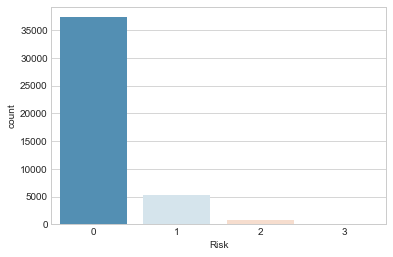

In [5]:
# view initial proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='RdBu_r')

In [6]:
# To increase balance of higher risk to lower risk, will group risk levels 1, 2, and 3 together as high risk and 0 as low risk:
allDataClean['Risk'] = allDataClean['Risk'].replace({0: 'low', 1: 'high', 2: 'high', 3: 'high'})

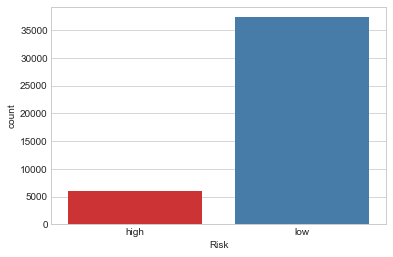

In [7]:
# Now, view new proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='Set1')

In [8]:
allDataClean.groupby('Risk').count()

,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI
Risk,,,,,,,
high,6066,6066,6066,6066,6066,6066,6066
low,37334,37334,37334,37334,37334,37334,37334


the dataset is still a bit unbalanced but is acceptable as higher risk for marjor cardio diseases  accounts for about 13% of the dataset.

To be balanced, 50% of our population would have high risk vs. 50% would have low risk.

Being unbalanced will influence an SVM model. 

##### In Step 9, (after feature selection), we use the Imbalanced-Learn library (built on top of Scikit-Learn) using the SMOTE algorithm to create a balanced dataset through oversampling

### Step4: Explore and Engineer Variables for Feature Selection

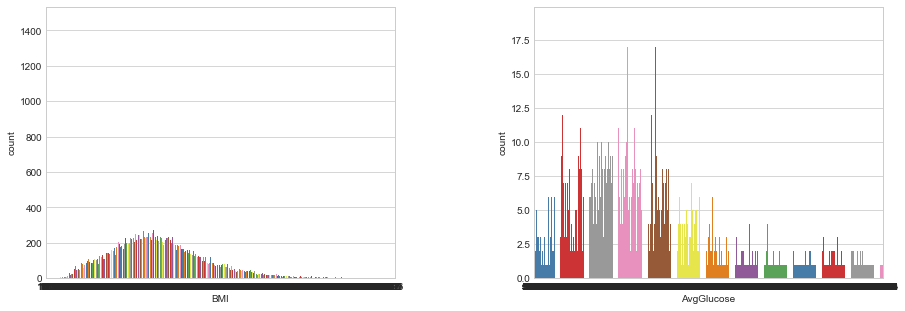

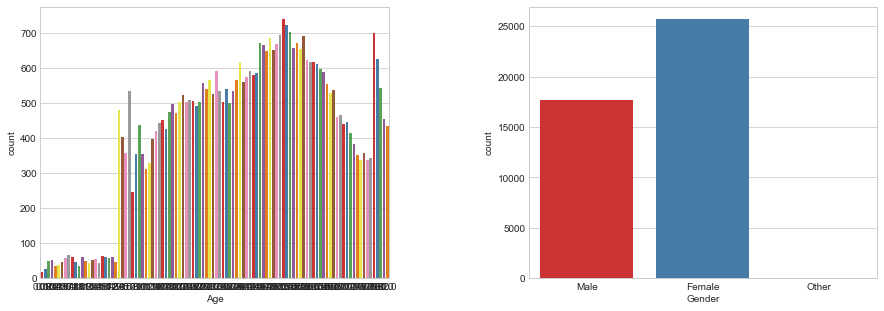

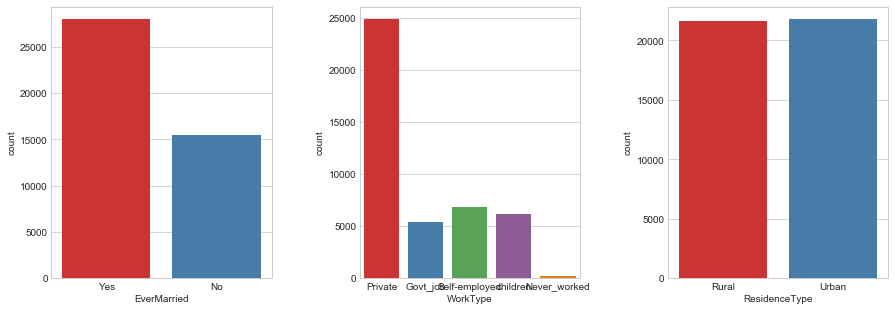

In [9]:
# view count by attribute
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',data=allDataClean,palette='Set1', ax=axs[2])

Observe that other gender and never_worked are underrepresented in Gender and Work Type

In [9]:
# delete 'other' category in gender since it's under-represented
allDataClean = allDataClean[allDataClean.Gender != 'Other']

# delete "Never_worked" category since under-represented
allDataClean = allDataClean[allDataClean.WorkType != 'Never_worked']

In [10]:
allDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43212 entries, 0 to 43399
Data columns (total 8 columns):
Gender           43212 non-null object
Age              43212 non-null float64
EverMarried      43212 non-null object
WorkType         43212 non-null object
ResidenceType    43212 non-null object
AvgGlucose       43212 non-null float64
BMI              43212 non-null float64
Risk             43212 non-null object
dtypes: float64(3), object(5)
memory usage: 3.0+ MB


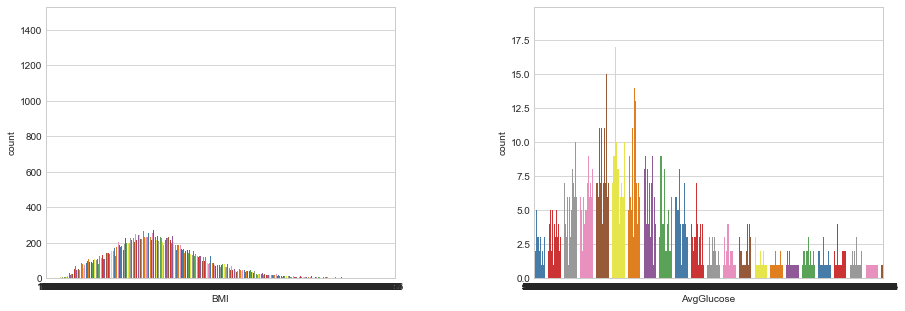

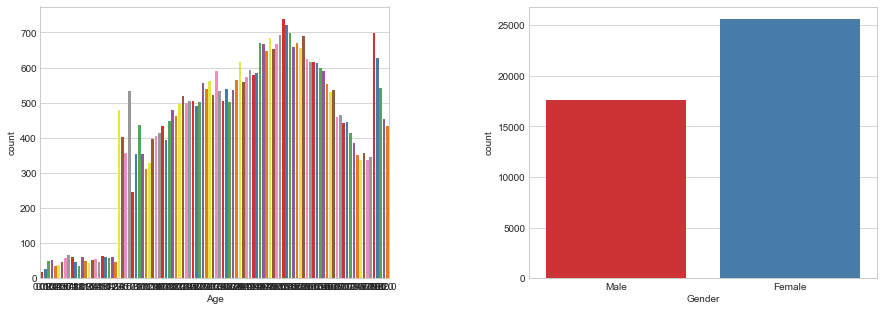

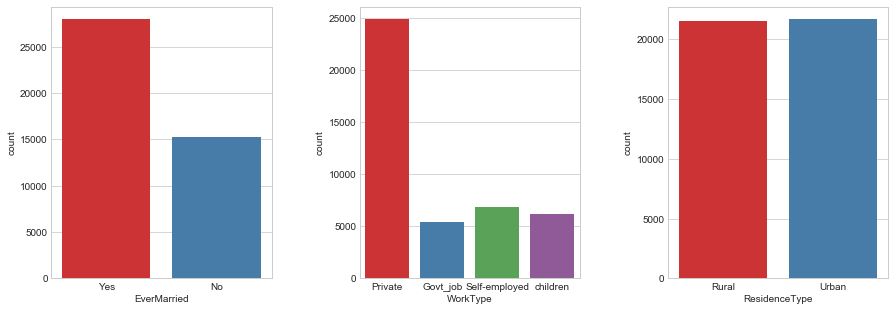

In [12]:
# view count by attribute
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',data=allDataClean,palette='Set1', ax=axs[2])

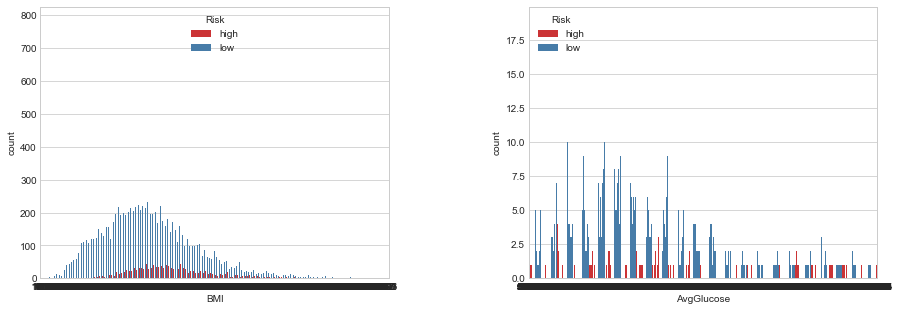

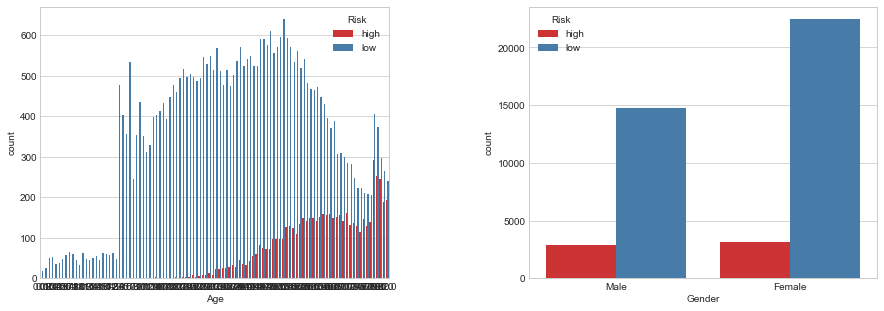

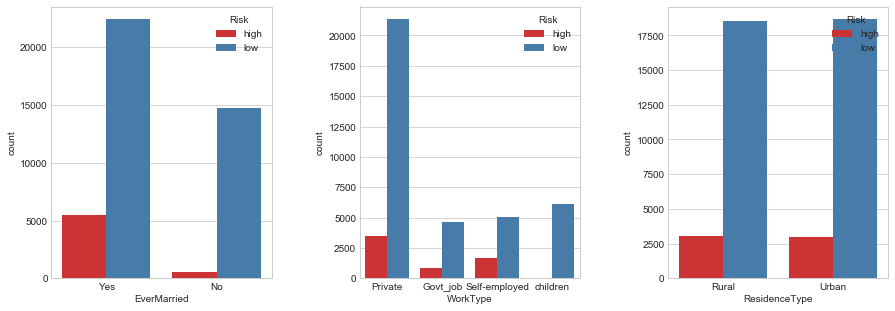

In [13]:
# view count of Risk by attribute (color = risk)
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',hue='Risk',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',hue='Risk',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',hue='Risk',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',hue='Risk',data=allDataClean,palette='Set1', ax=axs[2])

Younger ages are correlated with work type: "children", and "ever married" status of no, which makes sense as individuals under 18 are less likely to work or be married

In [11]:
# restrict age to greater than or equal to 20
# because <20 might influence marriage and work status
allDataClean = allDataClean[allDataClean.Age >= 20]
allDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34851 entries, 0 to 43399
Data columns (total 8 columns):
Gender           34851 non-null object
Age              34851 non-null float64
EverMarried      34851 non-null object
WorkType         34851 non-null object
ResidenceType    34851 non-null object
AvgGlucose       34851 non-null float64
BMI              34851 non-null float64
Risk             34851 non-null object
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


### Step5: Binary Encoding: Transform Categorical Features into Numeric

In [12]:
# Convert categorical data to numbers using binary encoding with get_dummies
allDataEncoded = allDataClean.copy()
# encode gender
genderFeatures = ['Gender']
allDataEncoded = pd.get_dummies(allDataClean,columns=genderFeatures,drop_first=True)
# then encode ever married
marriedFeatures = ['EverMarried']
allDataEncoded2 = pd.get_dummies(allDataEncoded,columns=marriedFeatures,drop_first=True)
# then encode work
workFeatures = ['WorkType']
allDataEncoded3 = pd.get_dummies(allDataEncoded2,columns=workFeatures,drop_first=True)
# then encode risk
encodeRisk = ['Risk']
allDataEncoded4 = pd.get_dummies(allDataEncoded3,columns=encodeRisk,drop_first=True)
# then encode res type
encodeRes = ['ResidenceType']
allDataEncoded7 = pd.get_dummies(allDataEncoded4,columns=encodeRes,drop_first=True)

# observe descriptive statistics related to new dummy variables
allDataEncoded7.describe()

,Age,AvgGlucose,BMI,Gender_Male,EverMarried_Yes,WorkType_Private,WorkType_Self-employed,Risk_low,ResidenceType_Urban
count,34851.000000,34851.000000,34851.000000,34851.000000,34851.000000,34851.000000,34851.000000,34851.000000,34851.000000
mean,50.220711,107.383477,30.289131,0.388224,0.800436,0.656509,0.191071,0.826433,0.502052
std,17.231672,45.991523,7.024755,0.487353,0.399678,0.474880,0.393150,0.378743,0.500003
min,20.000000,55.010000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,78.000000,25.500000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,92.600000,28.900000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,63.000000,114.770000,33.800000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,82.000000,291.050000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# view encoded dataset information again
allDataEncoded7.info() 
# observe that 4 variables are categorical and need to be converted

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34851 entries, 0 to 43399
Data columns (total 9 columns):
Age                       34851 non-null float64
AvgGlucose                34851 non-null float64
BMI                       34851 non-null float64
Gender_Male               34851 non-null uint8
EverMarried_Yes           34851 non-null uint8
WorkType_Private          34851 non-null uint8
WorkType_Self-employed    34851 non-null uint8
Risk_low                  34851 non-null uint8
ResidenceType_Urban       34851 non-null uint8
dtypes: float64(3), uint8(6)
memory usage: 1.3 MB


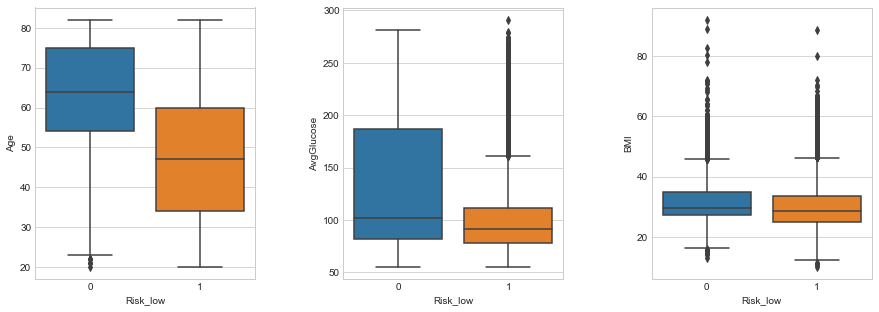

In [17]:
# explore outliers of continuous variables
fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.boxplot(x="Risk_low", y="Age", data=allDataEncoded7, ax=axs[0])
ax = sns.boxplot(x="Risk_low", y="AvgGlucose", data=allDataEncoded7, ax=axs[1])
ax = sns.boxplot(x="Risk_low", y="BMI", data=allDataEncoded7, ax=axs[2])

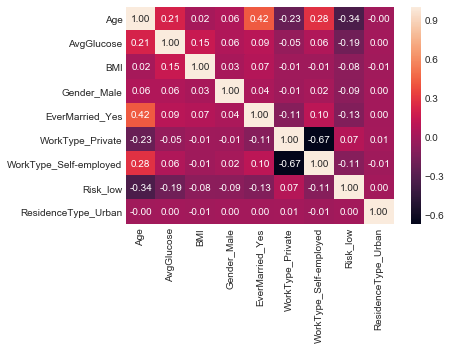

In [18]:
# explore multicolinearity of encoded data - in case consider using Naive Beyes model
sns.heatmap(allDataEncoded7.corr(), annot=True, fmt=".2f")
plt.show()

Younger ages are correlated with work type: "children", and "ever married" status of no, which makes sense as individuals under 18 are less likely to work or be married

##### Based on Steps 1-5 we have a basic understanding of the attributes' distributions, relationships, and outliers and are one step closer to concluding which features to include in our final model.

##### Next, we will split the data to build a decision tree and random forest in order to numerically observe the most important features.

### Step6: Split data into training set and testing set for evaluating feature importance

In [14]:
from sklearn.model_selection import train_test_split
X = allDataEncoded7.drop('Risk_low',axis=1)
y = allDataEncoded7['Risk_low']
y = np.array(y).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=71, stratify=y)

### Scaling and Normalizing the data

In [16]:
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


##### The data for our analysis has extreme outliers towards the maximum for X inputs "AvgGlucose" and "BMI"  indicated in the boxplots above. The distribution is so skewed that the mean is not a good measure of central tendency.  The red markers indicate those considered low risk for stroke - the blue markers indicate those considred not low risk.

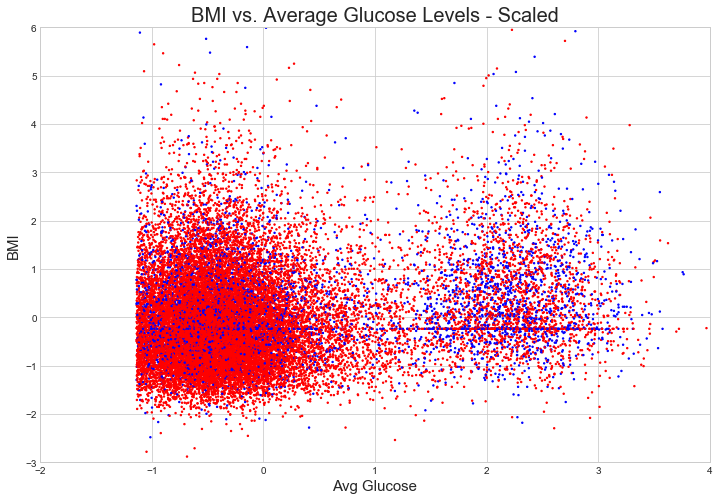

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,1], X_train[:,2], s=2, c=["b" if x==0 else "r" for x in y_train])
plt.xlim(-2,4)
plt.ylim(-3,6)
plt.xlabel("Avg Glucose",fontsize=15)
plt.ylabel("BMI",fontsize=15)
plt.title('BMI vs. Average Glucose Levels - Scaled', fontsize=20)
plt.show() 

### Step 7: train a decision tree model  to evaluate feature importance

In [18]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

#### predict and evaluate decision tree 

# create predictions from the test set
predictions = dtree.predict(X_test)

# create a classification report and a coonfusion matrix
# from sklearn.metrics import classification_report,confusion_matrix
# print(classification_report(y_test,predictions))

# print(confusion_matrix(y_test,predictions))

# print(f"Training Data Score: {dtree.score(X_train, y_train)}")
print(f"Average Accuracy Score of Testing Data: {dtree.score(X_test, y_test)}")

import os
import time
import sys

# use decision tree to consider feature importance
for i in range(3):
    
    t0 = time.time()
    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)
    t1 = time.time()
    
    ypred = clf.predict(X_test)
    scores = roc_auc_score(y_test, ypred)
    
    print(f"Decision tree {i+1} took {t1-t0} seconds to train and got a score of {scores}")
    print()
    print("And here are the top features: ")
    c = X.columns 
    for cfi in zip(c, clf.feature_importances_):
        print(cfi)
    print()

Average Accuracy Score of Testing Data: 0.7590956042694824
Decision tree 1 took 0.09075760841369629 seconds to train and got a score of 0.5872427605954199

And here are the top features: 
('Age', 0.2408776413783905)
('AvgGlucose', 0.3942936239662264)
('BMI', 0.24632094238044971)
('Gender_Male', 0.020307052317860338)
('EverMarried_Yes', 0.01774102906608308)
('WorkType_Private', 0.024377251351605227)
('WorkType_Self-employed', 0.021378661384677495)
('ResidenceType_Urban', 0.034703798154707255)

Decision tree 2 took 0.0967411994934082 seconds to train and got a score of 0.5882018517416379

And here are the top features: 
('Age', 0.24470756760023463)
('AvgGlucose', 0.39232203308796304)
('BMI', 0.2457129359462576)
('Gender_Male', 0.02245682567412776)
('EverMarried_Yes', 0.01599587115813213)
('WorkType_Private', 0.026166998114227173)
('WorkType_Self-employed', 0.01851625574741424)
('ResidenceType_Urban', 0.03412151267164344)

Decision tree 3 took 0.1077125072479248 seconds to train and got a

Based on decision tree, looks like glucose, bmi, and age are most important in predicting risk <br>
followed by residence type, worktype, marriage status and gender <br>

keep in mind that the average accuracy of this decision tree is only about 77%

### Step 8: Train a random forest model to evaluate potential features

In [19]:
X_train

array([[-0.30577901, -0.51467793, -0.96656906, ...,  0.72289168,
        -0.48653504, -1.0069104 ],
       [-1.69703083, -0.54215386, -0.60930193, ...,  0.72289168,
        -0.48653504, -1.0069104 ],
       [ 0.6217222 , -0.91167265,  0.66256905, ...,  0.72289168,
        -0.48653504,  0.99313702],
       ...,
       [-0.42171667, -0.36410119,  2.96336936, ...,  0.72289168,
        -0.48653504, -1.0069104 ],
       [ 1.37531694, -0.70614405,  0.10523233, ..., -1.38333312,
         2.05535041, -1.0069104 ],
       [ 0.04203394, -0.34419736,  0.71973179, ..., -1.38333312,
         2.05535041, -1.0069104 ]])

In [20]:
# create an instance of the random forest classifer class 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=25)
rfc.fit(X_train,y_train)
print(f"Average Accuracy Score of Testing Data: {rfc.score(X_test, y_test)}")
importances = rfc.feature_importances_
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Average Accuracy Score of Testing Data: 0.8141856995294388
                        importance
AvgGlucose                0.370204
BMI                       0.303187
Age                       0.268818
Gender_Male               0.013726
ResidenceType_Urban       0.012879
EverMarried_Yes           0.012407
WorkType_Self-employed    0.009660
WorkType_Private          0.009119


Based on random forest feature evaluation, 
- Glucose, BMI, and Age appear are most useful in predicting cardiovascular risk,
- followed by Marriage Status, residence type, and gender, 
- while work type appears to be least effective feature in cardiovascular risk prediction.

Because random forest's average accuracy is a bit higher, we will give more weight to it's ranking of feature importance

##### Decide to use Glucose, BMI, Age, Marriage Status, Residence Type, and Gender for Models

### Step 9. Create a dataframe to hold selected 'cleaned' variables for models

In [21]:
CleanedDataForModels = allDataEncoded7[['Risk_low', 'AvgGlucose', 'BMI', 'Age', 'EverMarried_Yes', 'ResidenceType_Urban', 'Gender_Male']]
CleanedDataForModels.to_csv("CleanedDataForModels.csv", index=False, encoding = 'utf-8')
CleanedDataForModels.head()

,Risk_low,AvgGlucose,BMI,Age,EverMarried_Yes,ResidenceType_Urban,Gender_Male
0,0,70.09,27.400000,74.0,1,0,1
1,0,84.03,26.500000,82.0,0,0,0
2,0,216.94,30.900000,71.0,0,0,1
3,0,72.17,36.800000,69.0,0,1,0
4,0,60.94,28.605038,79.0,0,0,0


---

## Part II: Use Selected Variables to Build Models

### Step10: Split dataset and create a balanced sample through over-sampling with SMOTE

In [22]:
# use the Imbalanced-Learn library (built on top of Scikit-Learn) using the SMOTE algorithm 
# to create a balanced sample.
#!pip install -U imbalanced-learn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
 
X = CleanedDataForModels.drop('Risk_low',axis=1)
y = CleanedDataForModels['Risk_low']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=71, stratify=y)
sm = SMOTE(random_state=12, ratio = 1.0)


X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


# Now, the dataset should be closer to 50-50
# X_train_res.groupby('ResidenceType_Urban').count()
# y_train.describe()


In [23]:
sds = StandardScaler()
sds.fit(X_train_res)

X_train_final = sds.transform(X_train_res)
X_test_final = sds.transform(X_test)

C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


In [24]:
joblib.dump(sds, "scaler.model2")

['scaler.model2']

In [25]:
np.mean(X_train_final, axis=0)

array([-1.66422655e-14, -1.57028015e-13,  5.20341473e-15, -8.15993853e-14,
       -2.27322546e-15, -2.04174003e-14])

In [26]:
np.mean(X_test_final, axis=0)

array([-0.16040428, -0.05693185, -0.31280374, -0.13168607, -0.00868404,
       -0.08311148])

### Step11: Build logistic regression, optimize on accuracy.

In [27]:
from sklearn.linear_model import LogisticRegression
# train the model with standard data
logmodel = LogisticRegression()
logmodel.fit(X_train_final, y_train_res)

# Now predict against standard test data
predictions = logmodel.predict(X_test_final)

# print classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.34      0.74      0.46      1512
           1       0.93      0.69      0.79      7201

   micro avg       0.70      0.70      0.70      8713
   macro avg       0.63      0.72      0.63      8713
weighted avg       0.82      0.70      0.74      8713



C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

[[1114  398]
 [2208 4993]]


In [29]:
# Create/Train logistic model with the *re-sampled* data
logmodelResampled = LogisticRegression()
logmodelResampled.fit(X_train_final,y_train_res)

# predict against standard test data
predictions = logmodelResampled.predict(X_test_final)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.34      0.74      0.46      1512
           1       0.93      0.69      0.79      7201

   micro avg       0.70      0.70      0.70      8713
   macro avg       0.63      0.72      0.63      8713
weighted avg       0.82      0.70      0.74      8713



C:\Users\Bonew\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
# print confusion matrix for re-sampled data
print(confusion_matrix(y_test,predictions))

[[1114  398]
 [2208 4993]]


In [31]:
# compare results from initial and re-sampled data

### Step 12: Build Support Vector Classifier, optimize on accuracy

## SVC Timing is not realistic, STAY AWAY

In [36]:
len(X_train_final)

43202

In [37]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train_final,y_train_res)

# Now predict values for the testing data
predictions = svc_model.predict(X_test_final)
from sklearn.metrics import classification_report,confusion_matrix
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.40      0.45      0.42      1512
           1       0.88      0.86      0.87      7201

   micro avg       0.79      0.79      0.79      8713
   macro avg       0.64      0.65      0.65      8713
weighted avg       0.80      0.79      0.79      8713



#### The Confusion matrix displays at [0,0]: predicted Not Low-Risk, actual Not Low-Risk.  At [0,1]:  predicted Low-Risk, actual Not Low-Risk. At [1,0]: predicted Not Low-Risk, actual Low-Risk. At [1,1]: predicted Low-Risk, actual Low-Risk.

In [51]:
print(confusion_matrix(y_test,predictions))

[[ 627  885]
 [ 883 6318]]


In [52]:
# run SVC with re-sampled data
from sklearn.svm import SVC
svc_model_resampled = SVC(kernel="sigmoid")
svc_model_resampled.fit(X_train_final,y_train_res)

# Now predict values for the standard testing data
predictions = svc_model_resampled.predict(X_test_final)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.26      0.63      0.37      1512
           1       0.89      0.62      0.73      7201

   micro avg       0.62      0.62      0.62      8713
   macro avg       0.57      0.62      0.55      8713
weighted avg       0.78      0.62      0.67      8713



In [53]:
# run SVC with re-sampled data
from sklearn.svm import SVC
svc_model_resampled = SVC(kernel="linear")
svc_model_resampled.fit(X_train_final,y_train_res)

# Now predict values for the standard testing data
predictions = svc_model_resampled.predict(X_test_final)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.33      0.76      0.45      1512
           1       0.93      0.67      0.78      7201

   micro avg       0.69      0.69      0.69      8713
   macro avg       0.63      0.71      0.62      8713
weighted avg       0.82      0.69      0.72      8713



# compare results from initial and re-sampled data

### Step 13. Build Decision Trees

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train_final, y_train_res)

# Now predict values for the testing data
predictions = dtree.predict(X_test_final)
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.31      0.35      0.32      1512
           1       0.86      0.83      0.85      7201

   micro avg       0.75      0.75      0.75      8713
   macro avg       0.58      0.59      0.59      8713
weighted avg       0.76      0.75      0.76      8713



In [33]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

[[ 523  989]
 [1190 6011]]


In [34]:
# build decision tree with re-sampled data
from sklearn.tree import DecisionTreeClassifier
dtree_resampled = DecisionTreeClassifier()
dtree_resampled.fit(X_train_final, y_train_res)

# Now predict values for the standard testing data
predictions = dtree_resampled.predict(X_test_final)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.30      0.34      0.32      1512
           1       0.86      0.83      0.85      7201

   micro avg       0.75      0.75      0.75      8713
   macro avg       0.58      0.59      0.58      8713
weighted avg       0.76      0.75      0.75      8713



In [35]:
# print confusion matrix with re-sampled data
print(confusion_matrix(y_test,predictions))

[[ 515  997]
 [1197 6004]]


In [36]:
# compare results from initial and re-sampled data

### Step 14: Build Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=25)
rfc.fit(X_train_final,y_train_res)

# Now predict values for the testing data
predictions = rfc.predict(X_test_final)
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.39      0.28      0.32      1512
           1       0.86      0.91      0.88      7201

   micro avg       0.80      0.80      0.80      8713
   macro avg       0.62      0.59      0.60      8713
weighted avg       0.77      0.80      0.78      8713



In [38]:
print(confusion_matrix(y_test,predictions))

[[ 418 1094]
 [ 667 6534]]


In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc_resampled = RandomForestClassifier(n_estimators=50, max_depth=15, max_leaf_nodes=200)
rfc_resampled.fit(X_train_final,y_train_res)

# Now predict values for the testing data
predictions = rfc_resampled.predict(X_test_final)
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.41      0.42      0.41      1512
           1       0.88      0.87      0.88      7201

   micro avg       0.79      0.79      0.79      8713
   macro avg       0.64      0.65      0.64      8713
weighted avg       0.80      0.79      0.80      8713



In [40]:
# print confusion matrix for resampled data
print(confusion_matrix(y_test,predictions))

[[ 630  882]
 [ 908 6293]]


In [42]:
joblib.dump(rfc_resampled, 'RandomForestFinal.model1')

['RandomForestFinal.model1']